<a href="https://colab.research.google.com/github/Hemanthtak2000/22073706_Project_UoH/blob/main/22073706_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title : Predictive Modeling for Vehicle Insurance to Optimize Customer Engagement

The project focuses on predictive modeling to identify customers who are more likely to purchase vehicle insurance, using data from those who have already bought health insurance from the same company. Addressing the class imbalance in the target variable (`Response`), the code includes preprocessing such as encoding categorical variables, removing outliers, scaling numerical features, and applying SMOTE for balancing the data. Several machine learning models, including Logistic Regression, Decision Tree, Random Forest, and Gaussian Naive Bayes, are trained and evaluated using metrics like Accuracy, ROC-AUC, and F1 scores. By implementing robust preprocessing, handling imbalance, and assessing model performance, the project aims to enhance customer targeting and engagement strategies.

In [ ]:
# Importing the libraries needed for the code implementation
import pandas as pd
from scipy.stats import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

### 1. Data Loading

This section loads the insurance data and performs initial checks for missing values and duplicates.

In [ ]:
# Read the data from csv file in Github
Ins_Details_path = 'https://raw.githubusercontent.com/Hemanthtak2000/22073706_Project_UoH/refs/heads/main/aug_train.csv'
Ins_Details = pd.read_csv(Ins_Details_path)
# Display the first 5 rows of the dataset
Ins_Details.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [ ]:
# Check for Null values
Ins_Details.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
# Checking the datatypes of each variable in the dataset
Ins_Details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


### 2. Data Pre-Processing

###### Feature Identification

Categorical and numerical features are identified for transformation and scaling.

In [ ]:
# Identifying al  l numerical features and categorical features from the dataset
numerical_features = Ins_Details.select_dtypes(exclude=['object']).columns.tolist()
print('The numerical features in the Insurance Dataset are:')
print(numerical_features)
categorical_features = Ins_Details.select_dtypes(include=['object']).columns.tolist()
print('\nThe Categorical features in the Insurance Dataset are:')
print(categorical_features)

The numerical features in the Insurance Dataset are:
['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

The Categorical features in the Insurance Dataset are:
['Gender', 'Vehicle_Age', 'Vehicle_Damage']


###### Label Encoding

Encoding categorical features to numeric values.

In [ ]:
# make an instance of Label Encoder
Labenc_Catfeat = LabelEncoder()

# transforming the Categorical variables into Numericals using Label Encoder
Ins_Details['Gender'] = Labenc_Catfeat.fit_transform(Ins_Details['Gender'])
Ins_Details['Vehicle_Age'] = Labenc_Catfeat.fit_transform(Ins_Details['Vehicle_Age'])
Ins_Details['Vehicle_Damage'] = Labenc_Catfeat.fit_transform(Ins_Details['Vehicle_Damage'])

###### Handling Duplicates

In [ ]:
# Checking for duplicates
Dup_Ins_Dtls = Ins_Details.duplicated()

# Display the number of duplicate rows
Total_Ins_Dup = Dup_Ins_Dtls.sum()
print(f'Number of duplicate rows: {Total_Ins_Dup}')

Number of duplicate rows: 0


In [ ]:
# Removing the Id columns as this is irrelavant
Ins_Details.drop(columns=['id'], inplace=True)

###### Outlier Detection and Removal

Outliers in Annual_Premium are handled using the IQR method.

In [ ]:
# Function for the detection of outliers
def detect_outliers_iqr(data, column):
    """
    Detect outliers in a dataset using the Interquartile Range (IQR) method.

    Parameters:
    data (DataFrame): The input pandas DataFrame containing the data.
    column (str): The name of the column in which to detect outliers.

    Returns:
    DataFrame: A subset of the input DataFrame containing rows that are outliers
               based on the IQR method.
    """

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check for outliers in the 'Annual_Premium' column
Out_Det_Ann_Pre = detect_outliers_iqr(Ins_Details, 'Annual_Premium')

# Display the number of outliers and the outlier rows
Count_Outliers = Out_Det_Ann_Pre.shape[0]
print(f'Number of outliers in Annual_Premium: {Count_Outliers}')
print(Out_Det_Ann_Pre)


Number of outliers in Annual_Premium: 10407
        Gender  Age  Driving_License  Region_Code  Previously_Insured  \
10           1   25                1          8.0                   1   
45           0   58                1         28.0                   0   
49           1   22                1          8.0                   0   
50           0   48                1         28.0                   0   
101          0   65                1         28.0                   1   
...        ...  ...              ...          ...                 ...   
382075       1   47                1         28.0                   0   
382089       0   66                1         28.0                   0   
382106       0   46                1          8.0                   0   
382120       0   48                1          8.0                   1   
382150       1   27                1         28.0                   1   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
10

In [ ]:
# Calculate the IQR bounds
Q1 = Ins_Details['Annual_Premium'].quantile(0.25)
Q3 = Ins_Details['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only values within the bounds
Ins_Details_PP_OL = Ins_Details[(Ins_Details['Annual_Premium'] >= lower_bound) & (Ins_Details['Annual_Premium'] <= upper_bound)]

# Display the new DataFrame shape after outlier removal
print(f'Original DataFrame shape: {Ins_Details.shape}')
print(f'DataFrame shape after outlier removal: {Ins_Details_PP_OL.shape}')


Original DataFrame shape: (382154, 11)
DataFrame shape after outlier removal: (371747, 11)


###### Scaling

In [ ]:
# Initialize a StandardScaler
scaler = StandardScaler()
# Apply the scaler to the 'Annual_Premium' column
Ins_Details_PP_OL.loc[:, ['Annual_Premium']] = scaler.fit_transform(Ins_Details_PP_OL[['Annual_Premium']])

In [ ]:
# Checking the Dataset info after pre-processing
Ins_Details_PP_OL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371747 entries, 0 to 382153
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                371747 non-null  int64  
 1   Age                   371747 non-null  int64  
 2   Driving_License       371747 non-null  int64  
 3   Region_Code           371747 non-null  float64
 4   Previously_Insured    371747 non-null  int64  
 5   Vehicle_Age           371747 non-null  int64  
 6   Vehicle_Damage        371747 non-null  int64  
 7   Annual_Premium        371747 non-null  float64
 8   Policy_Sales_Channel  371747 non-null  float64
 9   Vintage               371747 non-null  int64  
 10  Response              371747 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 34.0 MB


In [ ]:
# Printing the first 5 rows of the data after pre-processing
Ins_Details_PP_OL.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,22,1,7.0,1,1,0,-1.832904,152.0,16,0
1,1,42,1,28.0,0,0,1,0.952118,26.0,135,0
2,0,66,1,33.0,0,0,1,0.439828,124.0,253,0
3,0,22,1,33.0,0,1,0,-0.121050,152.0,69,0
4,1,28,1,46.0,1,1,0,-0.026749,152.0,211,0


### 3. Exploratory Data Analysis (EDA)

Visualizing distributions and correlations between features.

###### Class Imbalance Visualization

In [ ]:
# Printing to See unique values in the response and its count
class_counts = Ins_Details_PP_OL['Response'].value_counts()
print(class_counts)

Response
0    311222
1     60525
Name: count, dtype: int64


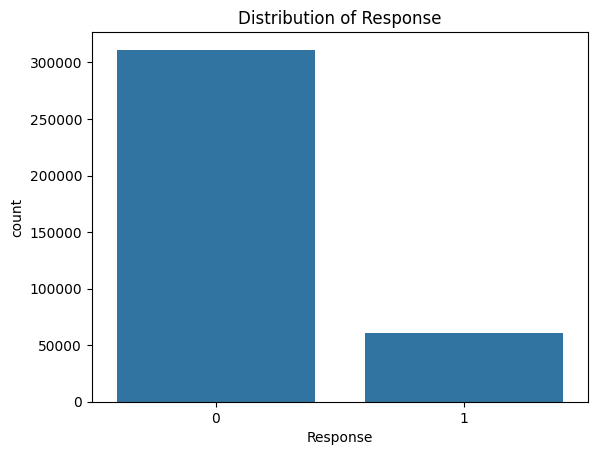

In [ ]:
# Visualize the Response variable Distribution
sns.countplot(x='Response', data=Ins_Details_PP_OL)
# Adding the title to the plot
plt.title('Distribution of Response')
# Display the plot
plt.show()

###### Annual Premium destribution and Outliers Visualization

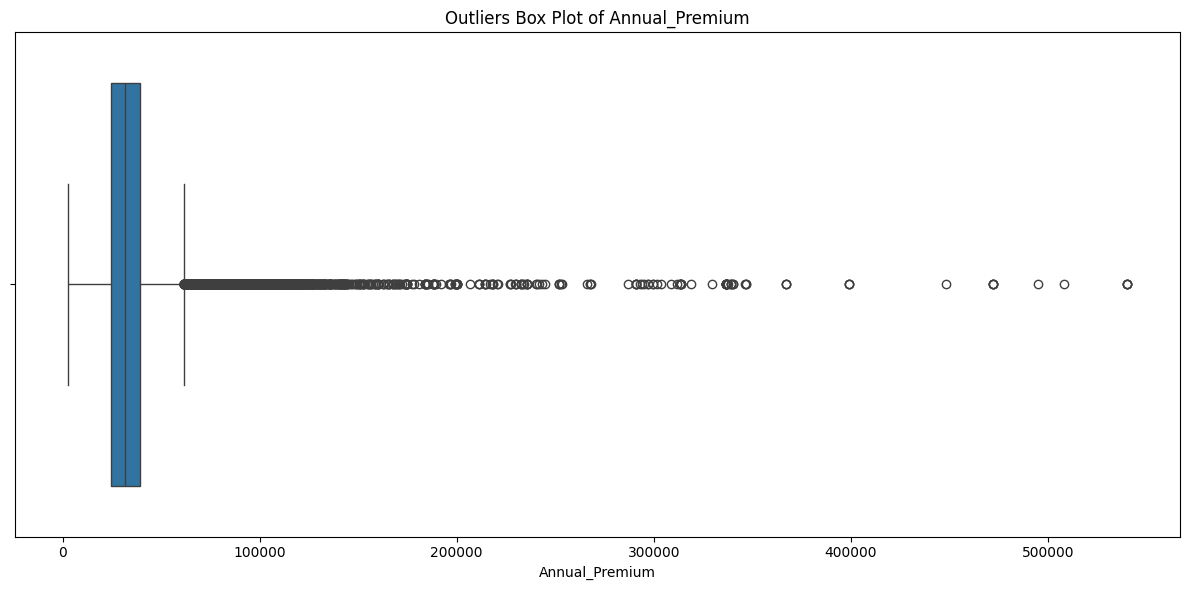

In [ ]:
# Annual premium beox plot before scaling and outlier removal
plt.figure(figsize=(12, 6))
sns.boxplot(x=Ins_Details['Annual_Premium'])
plt.title('Outliers Box Plot of Annual_Premium')
plt.tight_layout()
plt.show()

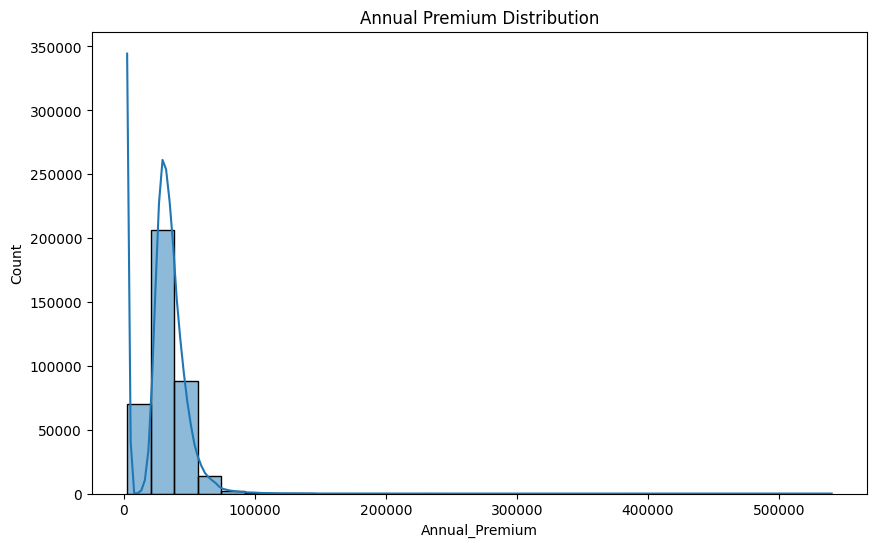

In [ ]:
# Annual Premium Distribution before Outliers removal and scaling
plt.figure(figsize=(10, 6))
sns.histplot(Ins_Details['Annual_Premium'], kde=True, bins=30)
plt.title('Annual Premium Distribution')
plt.show()

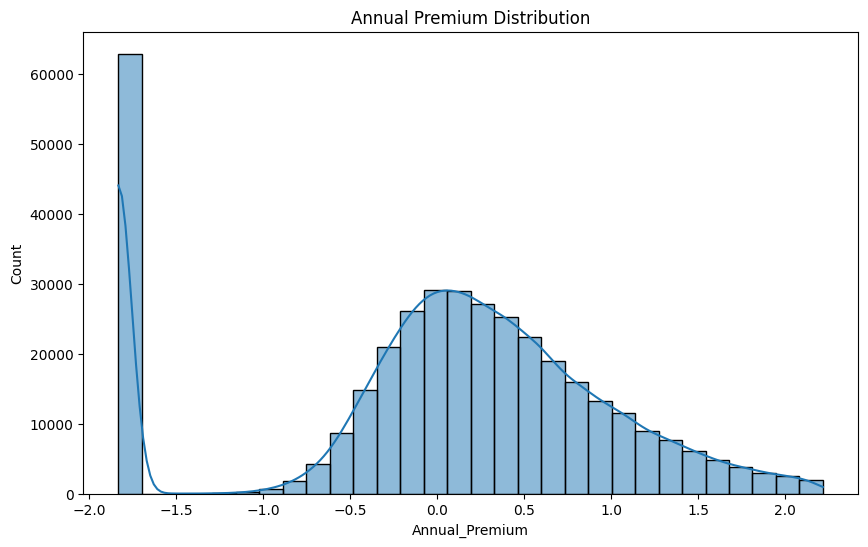

In [ ]:
# Annual Premium Distribution after Outliers removal and scaling
plt.figure(figsize=(10, 6))
sns.histplot(Ins_Details_PP_OL['Annual_Premium'], kde=True, bins=30)
plt.title('Annual Premium Distribution')
plt.show()

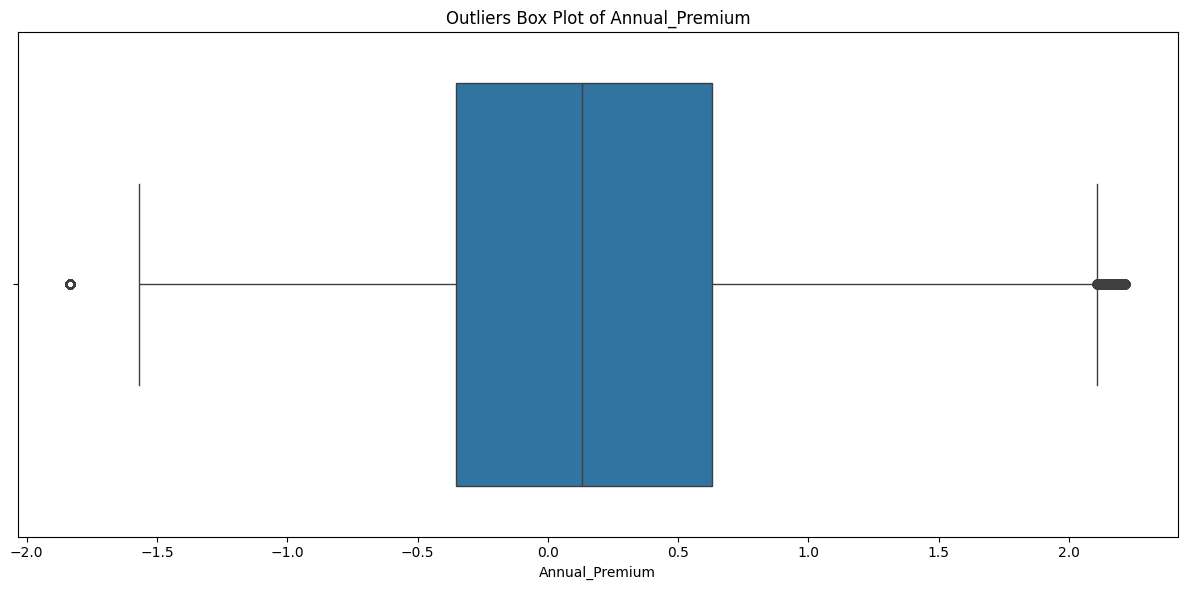

In [ ]:
# Box plot for Annual premium after outlier removal
plt.figure(figsize=(12, 6))
sns.boxplot(x=Ins_Details_PP_OL['Annual_Premium'])
plt.title('Outliers Box Plot of Annual_Premium')
plt.tight_layout()
plt.show()


###### Correlation Analysis

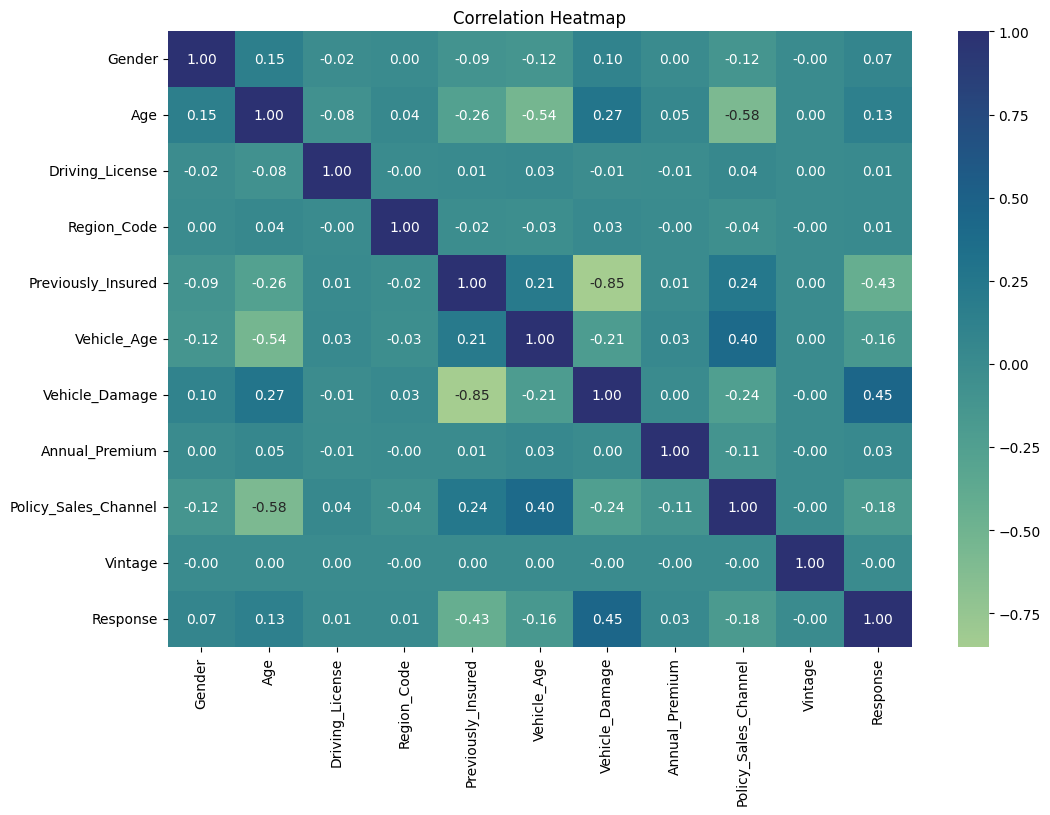

In [ ]:
# Calculate the correlation matrix using the dataset
correlation_matrix = Ins_Details_PP_OL.corr()
# Create a figure
plt.figure(figsize=(12, 8))
#Producing heatmap using the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
#Set the title
plt.title('Correlation Heatmap')
# Display the plot
plt.show()


###### Distribution Plots

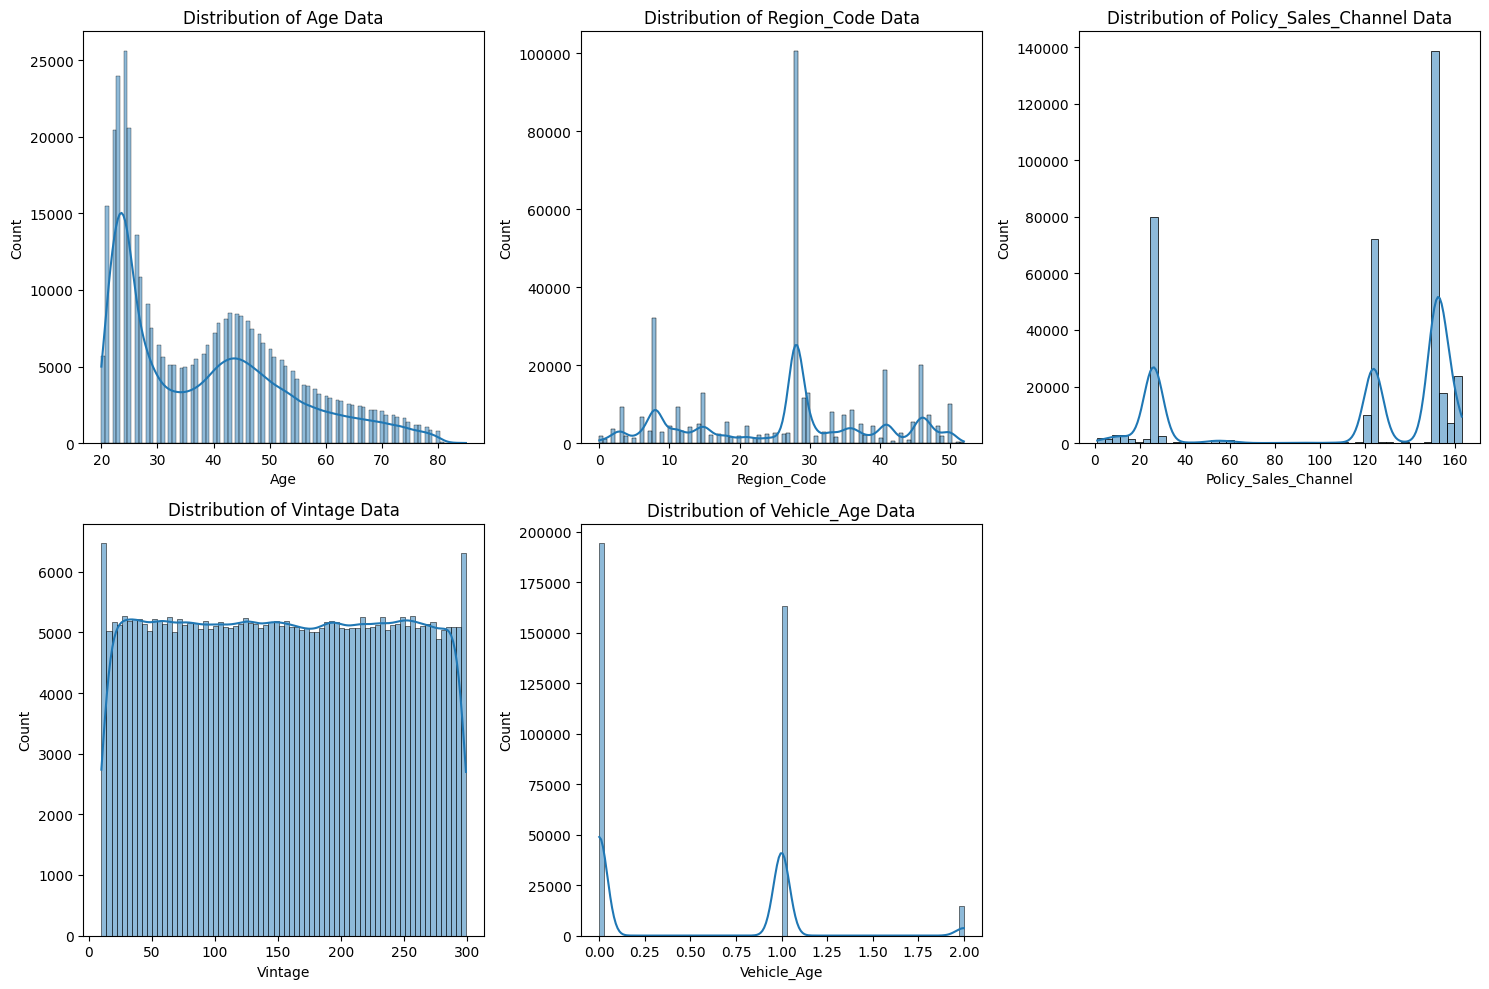

In [ ]:
# code for distribution plots
col_list = ['Age', 'Region_Code', 'Policy_Sales_Channel',
            'Vintage','Vehicle_Age']
# Create figure and histograms
plt.figure(figsize=(15,10))
for i,col in enumerate(col_list,1):
    plt.subplot(2,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(Ins_Details_PP_OL[col],kde=True)
    plt.tight_layout()
    plt.plot()

### Models Implementation

In [ ]:
# Initialize lists to store model names and their evaluation metrics
models = []
accuracy_values = []
roc_auc_values = []
f1_score_values = []

def record_and_print_scores(model_name, test_result, pred_result, proba_val):
    """
    Record and display evaluation metrics for a given model.

    This function computes and displays a confusion matrix, classification report,
    and key evaluation metrics accuracy, ROC AUC, F1 score for a model. It also
    plots the ROC curve and stores the results for comparison.

    Parameters:
    model_name (str): Name of the model being evaluated.
    test_result (array-like): True labels of the test dataset.
    pred_result (array-like): Predicted labels by the model.
    proba_val (array-like): Predicted probabilities for the positive class.
    """
    # Calculate and display the confusion matrix
    print(f'\nConfusion Matrix for {model_name}\n')
    cm = confusion_matrix(test_result, pred_result)
    tn, fp, fn, tp = cm.ravel()
    print(f'True Negative  : {tn}\nFalse Positive : {fp}\nFalse Negative : {fn}\nTrue Positive  : {tp}')

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}\n')
    plt.show()

    # Display the classification report
    print(f'\nClassification Report for {model_name}\n\n')
    print(classification_report(test_result, pred_result))

    # Compute evaluation metrics
    x_acc_score = accuracy_score(test_result, pred_result)
    x_roc_acu = roc_auc_score(test_result, pred_result)
    x_f1_score = f1_score(test_result, pred_result)

    # Print the evaluation metrics
    print(f'\n\nResults for {model_name}\n\n')
    print(f'Accuracy is: {x_acc_score:.2f}')
    print(f'ROC AUC is : {x_roc_acu:.2f}')
    print(f'F1 Score is : {x_f1_score:.2f}')

    # Append metrics to the respective lists
    models.append(model_name)
    accuracy_values.append(x_acc_score)
    roc_auc_values.append(x_roc_acu)
    f1_score_values.append(x_f1_score)

    # Plot the ROC curve
    print(f'\nROC Curve for {model_name}\n\n')
    fpr, tpr, threshold = roc_curve(test_result, proba_val)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % x_roc_acu)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random performance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}\n')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Separate the features (X) and the target variable (y) from the dataset
X = Ins_Details_PP_OL.drop(['Response'], axis=1)
y = Ins_Details_PP_OL['Response']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3706)
# Initialize SMOTE
smote = SMOTE(random_state=3706)
# Apply SMOTE to oversample the minority class in the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



Confusion Matrix for Logistic Regression

True Negative  : 42049
False Positive : 20079
False Negative : 1213
True Positive  : 11009


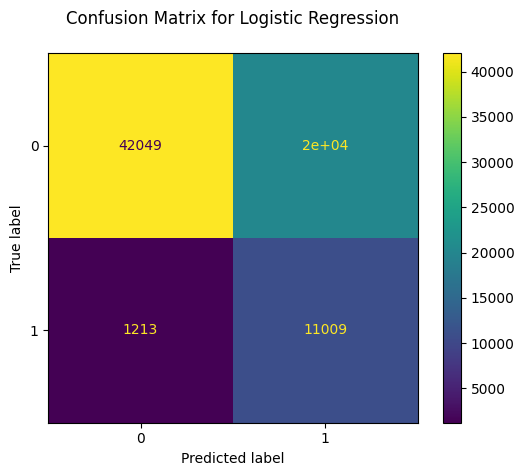


Classification Report for Logistic Regression


              precision    recall  f1-score   support

           0       0.97      0.68      0.80     62128
           1       0.35      0.90      0.51     12222

    accuracy                           0.71     74350
   macro avg       0.66      0.79      0.65     74350
weighted avg       0.87      0.71      0.75     74350



Results for Logistic Regression


Accuracy is: 0.71
ROC AUC is : 0.79
F1 Score is : 0.51

ROC Curve for Logistic Regression




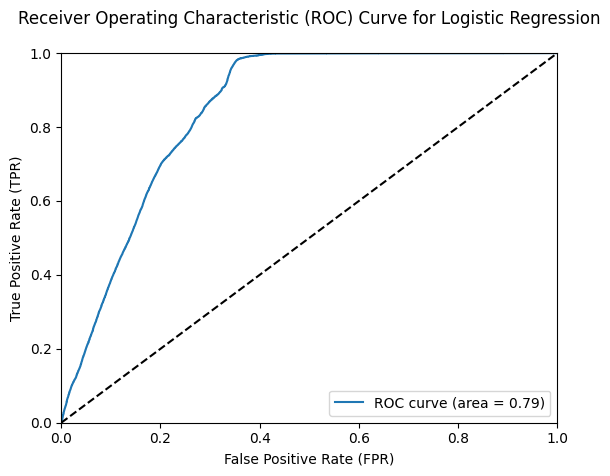

In [ ]:
# Create an instance of Logistic Regression Model
LRmodel = LogisticRegression(penalty='l2', C=1, solver='lbfgs')

# Train the model using model.fit
LRmodel.fit(X_train_resampled, y_train_resampled)

# Predict the results for the Test data
y_pred = LRmodel.predict(X_test)

# Find the Prediction Probability of the Test data
y_pred_proba = LRmodel.predict_proba(X_test)[:,1]
#Evaluate using function
record_and_print_scores('Logistic Regression', y_test, y_pred, y_pred_proba)



Confusion Matrix for Decision Tree Classifier

True Negative  : 52993
False Positive : 9135
False Negative : 5383
True Positive  : 6839


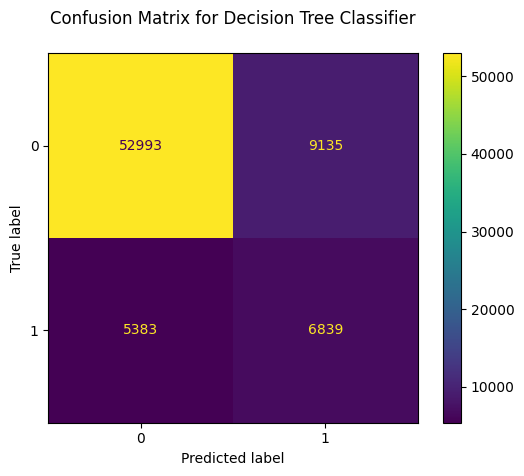


Classification Report for Decision Tree Classifier


              precision    recall  f1-score   support

           0       0.91      0.85      0.88     62128
           1       0.43      0.56      0.49     12222

    accuracy                           0.80     74350
   macro avg       0.67      0.71      0.68     74350
weighted avg       0.83      0.80      0.81     74350



Results for Decision Tree Classifier


Accuracy is: 0.80
ROC AUC is : 0.71
F1 Score is : 0.49

ROC Curve for Decision Tree Classifier




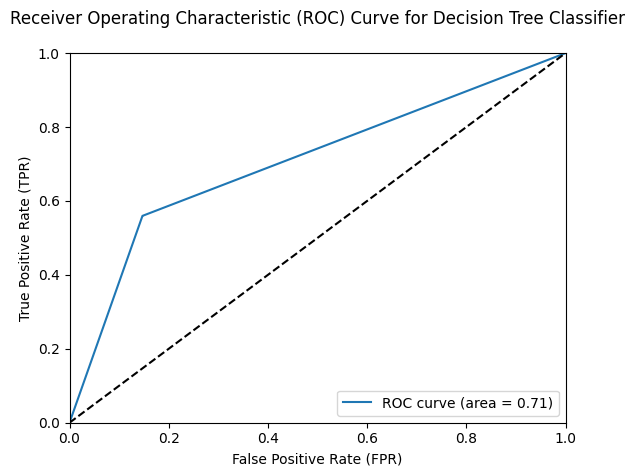

In [ ]:
# Initialize the deciontree
dtree = DecisionTreeClassifier()

# Train and Fit the model using model.fit
dtree.fit(X_train_resampled, y_train_resampled)

# Predict the results for the Test data
y_pred = dtree.predict(X_test)

# Find the Prediction Probability of the Test data
y_pred_proba = dtree.predict_proba(X_test)[:,1]
# Evaluate using function
record_and_print_scores('Decision Tree Classifier', y_test, y_pred, y_pred_proba)


Confusion Matrix for Random Forest Classifier

True Negative  : 52513
False Positive : 9615
False Negative : 3817
True Positive  : 8405


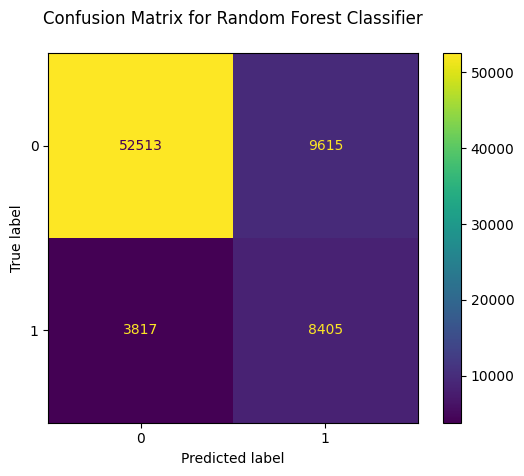


Classification Report for Random Forest Classifier


              precision    recall  f1-score   support

           0       0.93      0.85      0.89     62128
           1       0.47      0.69      0.56     12222

    accuracy                           0.82     74350
   macro avg       0.70      0.77      0.72     74350
weighted avg       0.86      0.82      0.83     74350



Results for Random Forest Classifier


Accuracy is: 0.82
ROC AUC is : 0.77
F1 Score is : 0.56

ROC Curve for Random Forest Classifier




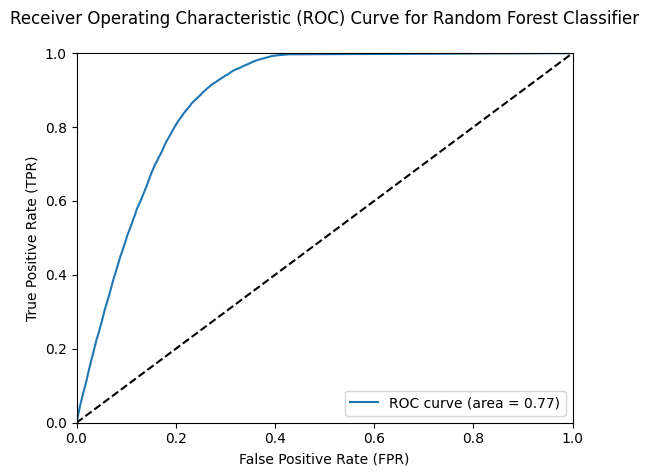

In [ ]:
# Create the Random Forest Classifier instance
rfc = RandomForestClassifier(n_estimators=100)

# Train and Fit the model using model.fit
rfc.fit(X_train_resampled, y_train_resampled)
# Predict the results for the Test data
y_pred = rfc.predict(X_test)

# Find the Prediction Probability of the Test data
y_pred_proba = rfc.predict_proba(X_test)[:,1]

record_and_print_scores('Random Forest Classifier', y_test, y_pred, y_pred_proba)


Confusion Matrix for Gaussian Naive Bayes

True Negative  : 40218
False Positive : 21910
False Negative : 188
True Positive  : 12034


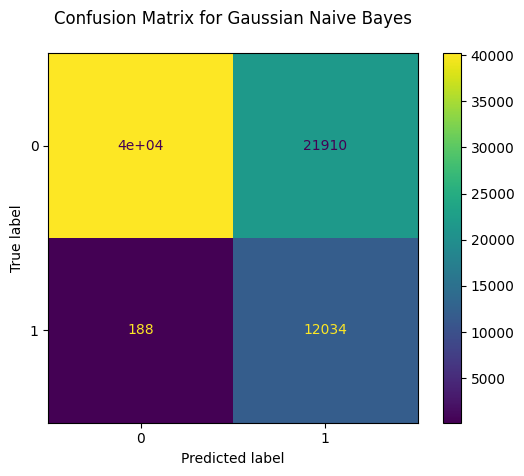


Classification Report for Gaussian Naive Bayes


              precision    recall  f1-score   support

           0       1.00      0.65      0.78     62128
           1       0.35      0.98      0.52     12222

    accuracy                           0.70     74350
   macro avg       0.67      0.82      0.65     74350
weighted avg       0.89      0.70      0.74     74350



Results for Gaussian Naive Bayes


Accuracy is: 0.70
ROC AUC is : 0.82
F1 Score is : 0.52

ROC Curve for Gaussian Naive Bayes




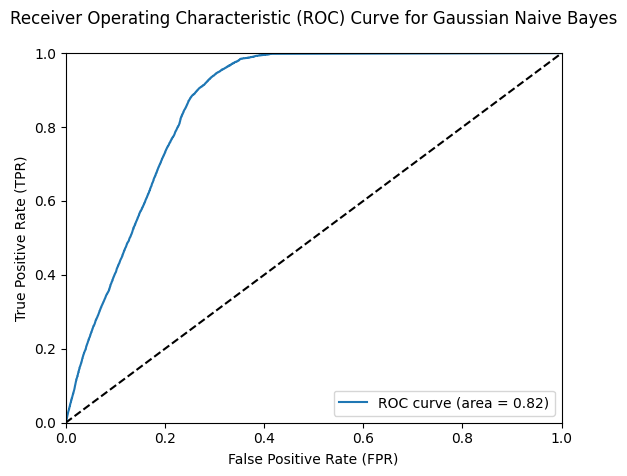

In [ ]:
# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train_resampled, y_train_resampled)

# Predict the response for test dataset
y_pred = gnb.predict(X_test)

# Find the Prediction Probability of the Test data
y_pred_proba = gnb.predict_proba(X_test)[:,1]

record_and_print_scores('Gaussian Naive Bayes', y_test, y_pred, y_pred_proba)

### Result Summary

In [ ]:
# Create a dictionary to store evaluation metrics for each model
prediction_dict = {
    'Accuracy': accuracy_values,
    'ROC AUC': roc_auc_values,
    'F1 Score': f1_score_values  }

# Convert the dictionary into a DataFrame for easier visualization
dx = pd.DataFrame(prediction_dict, index=models)

# Set the display precision for floating-point numbers
pd.set_option('display.precision', 2)

# Display the DataFrame with the evaluation metrics
dx


,Accuracy,ROC AUC,F1 Score
Logistic Regression,0.71,0.79,0.51
Decision Tree Classifier,0.80,0.71,0.49
Random Forest Classifier,0.82,0.77,0.56
Gaussian Naive Bayes,0.70,0.82,0.52
